# 📌 1. Introduction
- This notebook presents my solutions for the Computer Vision Technical Assessment.
Each task is implemented with a clear methodology and documented code.
Images are enhanced, text is extracted using OCR techniques, super-resolution is applied,
and object extraction is demonstrated.

# 📂 2. Environment Setup

In [1]:
!pip install pytesseract
!pip install scikit-image
!pip install easyocr

# !pip install python-doctr[torch]
# !pip install -U ultralytics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [14]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import easyocr
# Create the reader object (English only)
reader = easyocr.Reader(['en'])



from easyocr import Reader
from skimage.metrics import structural_similarity as ssim


#  3.1 Task 1: Image Enhancement
###**Objective:**
Enhance the provided images using multiple image processing techniques.

---



In [3]:
def adaptive_gamma_correction(img, is_img1=True):
    """
    Apply adaptive gamma correction with parameters tuned for each image.
    """
    img_normalized = img / 255.0
    mean_intensity = np.mean(img_normalized)
    # Different gamma tuning for each image
    if is_img1:
        gamma = 3.0 / (1.0 + mean_intensity) if mean_intensity > 0 else 1.0  # Stronger for img1 (very dark)
    else:
        gamma = 1.5 / (1.0 + mean_intensity) if mean_intensity > 0 else 1.0  # Milder for img2 (better lighting)
    img_gamma = np.power(img_normalized, gamma)
    img_gamma = np.uint8(img_gamma * 255)
    return img_gamma



def enhance_methods(img, is_img1=True):
    """
    Apply enhancement methods with parameters tuned for each image.
    """
    # Step 1: Denoising using Non-Local Means
    if is_img1:
        # Stronger denoising for img1 due to high noise
        denoised = cv2.fastNlMeansDenoisingColored(img, None, h=15, hColor=15, templateWindowSize=7, searchWindowSize=21)
    else:
        # Lighter denoising for img2 as noise is less
        denoised = cv2.fastNlMeansDenoisingColored(img, None, h=5, hColor=5, templateWindowSize=7, searchWindowSize=21)

    # Convert to HSV for Histogram Equalization and CLAHE
    img_hsv = cv2.cvtColor(denoised, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)

    # 1. Histogram Equalization (on Value channel)
    hist_eq_v = cv2.equalizeHist(v)
    hist_eq_hsv = cv2.merge([h, s, hist_eq_v])
    hist_eq = cv2.cvtColor(hist_eq_hsv, cv2.COLOR_HSV2BGR)

    # 2. CLAHE (on Value channel)
    if is_img1:
        # Higher clipLimit for img1 to boost contrast
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    else:
        # Moderate clipLimit for img2 to avoid over-enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_v = clahe.apply(v)
    clahe_hsv = cv2.merge([h, s, clahe_v])
    clahe_eq = cv2.cvtColor(clahe_hsv, cv2.COLOR_HSV2BGR)

    # 3. Bilateral Filter + Sharpening
    if is_img1:
        # Stronger bilateral for img1 to reduce noise further
        bilateral = cv2.bilateralFilter(denoised, d=9, sigmaColor=75, sigmaSpace=75)
    else:
        # Lighter bilateral for img2 to preserve details
        bilateral = cv2.bilateralFilter(denoised, d=9, sigmaColor=30, sigmaSpace=30)
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    bilateral_sharp = cv2.filter2D(bilateral, -1, kernel_sharp)

    # 4. Unsharp Masking
    if is_img1:
        # Stronger unsharp for img1 to enhance text edges
        gaussian = cv2.GaussianBlur(denoised, (9, 9), 10.0)
        unsharp = cv2.addWeighted(denoised, 2.5, gaussian, -0.5, 0)
    else:
        # Moderate unsharp for img2
        gaussian = cv2.GaussianBlur(denoised, (5, 5), 5.0)
        unsharp = cv2.addWeighted(denoised, 1.5, gaussian, -0.5, 0)

    # 5. Adaptive Gamma Correction
    gamma_corrected = adaptive_gamma_correction(denoised, is_img1)

    # 6. Morphological Operation (Opening to enhance text)
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    if is_img1:
        # Larger kernel for img1 to clean more noise
        kernel = np.ones((4, 4), np.uint8)
    else:
        # Smaller kernel for img2 to preserve details
        kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    morph_color = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)

    return hist_eq, clahe_eq, bilateral_sharp, unsharp, gamma_corrected, morph_color



In [4]:
def show_images(images, titles):
    """
    Display images with their titles using matplotlib.
    """
    plt.figure(figsize=(15, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Process both images with different parameters
def process_image(image_path, is_img1=True):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image {image_path}. Check the file path.")
        return
    hist_eq, clahe_eq, bilateral_sharp, unsharp, gamma_corrected, morph = enhance_methods(img, is_img1)
    show_images(
        [img, hist_eq, clahe_eq, bilateral_sharp, unsharp, gamma_corrected, morph],
        ["Original", "Histogram Equalization", "CLAHE", "Bilateral + Sharpen", "Unsharp Masking", "Adaptive Gamma Correction", "Morphological Opening"]
    )

## **First Image (task1_img1- E1SU92213882)**
- **Issues**: The text is relatively clear, but the contrast between the text and the background can be improved, and there may be slight noise or minor blur.

- **Priorities**:
  *   Moderately improve contrast (CLAHE).
  *   Increase text sharpness (Sharpening or Unsharp Masking).
  *   Reduce slight noise if present (Denoising).




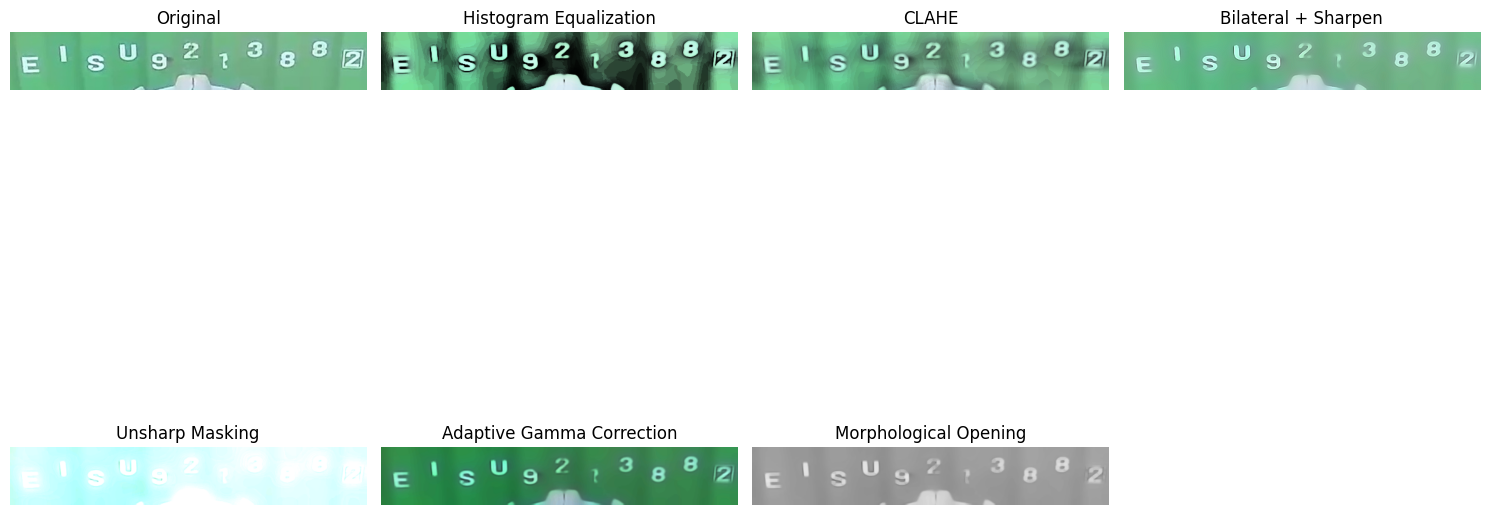

In [5]:
# Process both images
task1_img1_process=process_image("task1_img1.jpg", is_img1=True)  # For E1SU92213882 image
task1_img1_process

## **Second Image (task1_img2- PCIU0212170)**
- **Issues**: High noise, very low contrast, text is unclear.

- **Priorities**:
  *   Significantly reduce noise (Denoising).
  *   Strongly increase contrast (CLAHE or Histogram Equalization).
  * Enhance edges to highlight the text (Unsharp Masking or Morphological Operations).




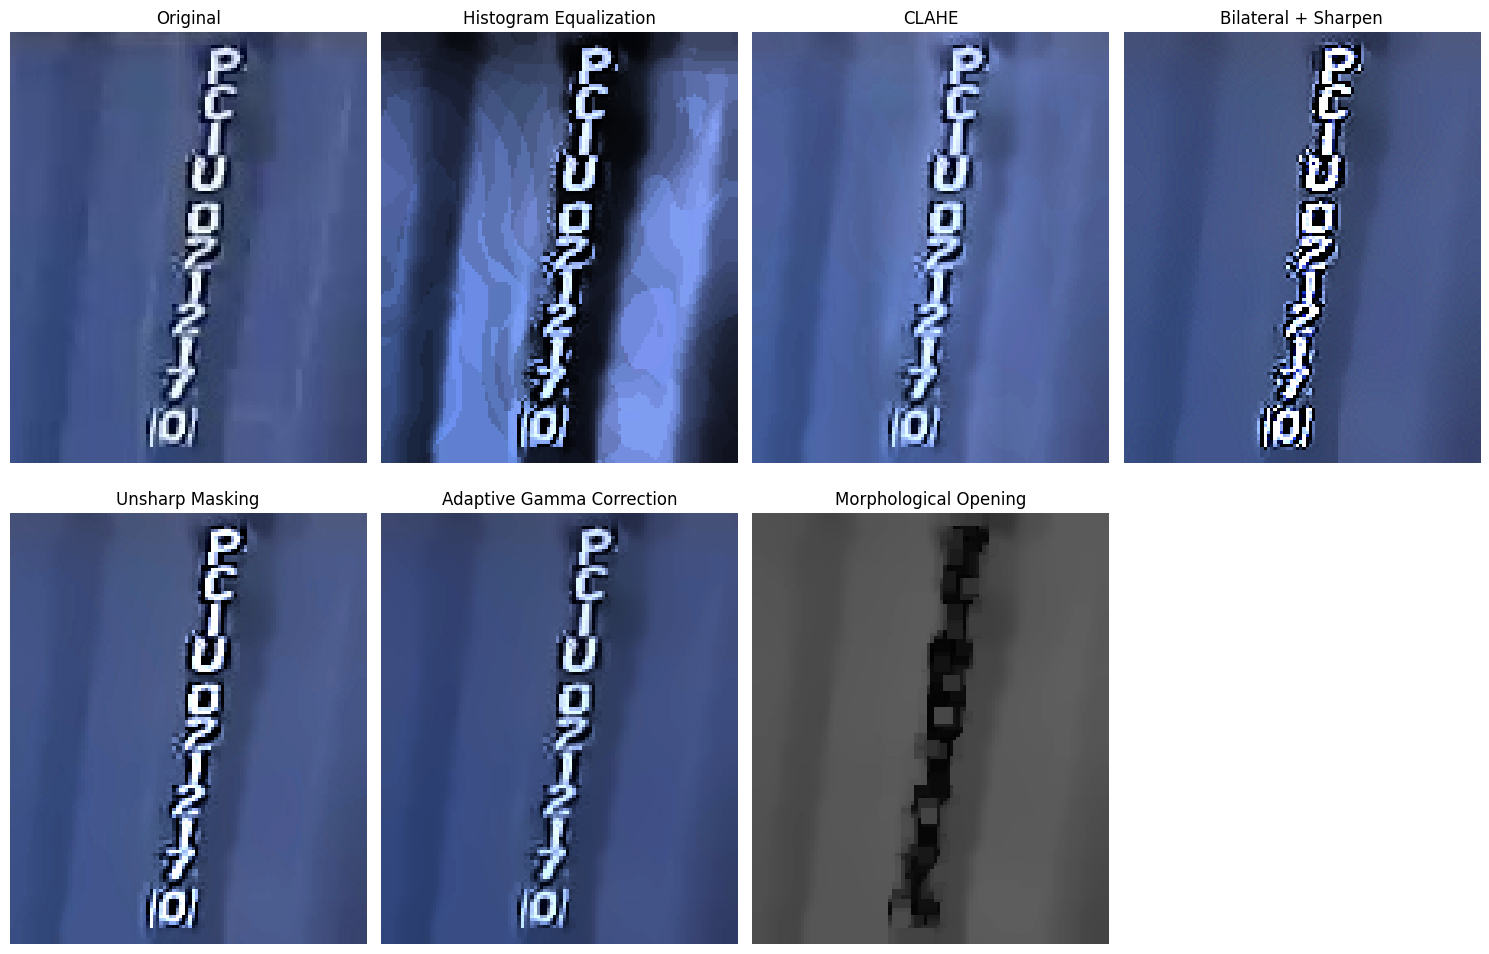

In [6]:
task1_img2_process=process_image("task1_img2.jpg", is_img1=False)  # For PCIU0212170 image
task1_img2_process

In [7]:
def adaptive_gamma_correction(img, is_img1=True):
    """
    Apply adaptive gamma correction with parameters tuned for each image.
    """
    img_normalized = img / 255.0
    mean_intensity = np.mean(img_normalized)
    # Different gamma tuning for each image
    if is_img1:
        gamma = 3.0 / (1.0 + mean_intensity) if mean_intensity > 0 else 1.0  # Stronger for img1 (very dark)
    else:
        gamma = 1.5 / (1.0 + mean_intensity) if mean_intensity > 0 else 1.0  # Milder for img2 (better lighting)
    img_gamma = np.power(img_normalized, gamma)
    img_gamma = np.uint8(img_gamma * 255)
    return img_gamma

def compute_ssim(original, enhanced):
    """
    Compute the SSIM between the original and enhanced images.

    Parameters:
    - original: The original image (grayscale or color).
    - enhanced: The enhanced image (grayscale or color).

    Returns:
    - SSIM score.
    """
    # Convert images to grayscale for SSIM computation
    if len(original.shape) == 3:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original
    if len(enhanced.shape) == 3:
        enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    else:
        enhanced_gray = enhanced

    # Compute SSIM (multichannel=False since we're using grayscale)
    score, _ = ssim(original_gray, enhanced_gray, full=True)
    return score


def enhance_methods(img, is_img1=True):
    """
    Apply enhancement methods with parameters tuned for each image.
    """
    # Step 1: Denoising using Non-Local Means
    if is_img1:
        # Stronger denoising for img1 due to high noise
        denoised = cv2.fastNlMeansDenoisingColored(img, None, h=15, hColor=15, templateWindowSize=7, searchWindowSize=21)
    else:
        # Lighter denoising for img2 as noise is less
        denoised = cv2.fastNlMeansDenoisingColored(img, None, h=5, hColor=5, templateWindowSize=7, searchWindowSize=21)

    # Convert to HSV for Histogram Equalization and CLAHE
    img_hsv = cv2.cvtColor(denoised, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)

    # 1. Histogram Equalization (on Value channel)
    hist_eq_v = cv2.equalizeHist(v)
    hist_eq_hsv = cv2.merge([h, s, hist_eq_v])
    hist_eq = cv2.cvtColor(hist_eq_hsv, cv2.COLOR_HSV2BGR)

    # 2. CLAHE (on Value channel)
    if is_img1:
        # Higher clipLimit for img1 to boost contrast
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    else:
        # Moderate clipLimit for img2 to avoid over-enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_v = clahe.apply(v)
    clahe_hsv = cv2.merge([h, s, clahe_v])
    clahe_eq = cv2.cvtColor(clahe_hsv, cv2.COLOR_HSV2BGR)

    # 3. Bilateral Filter + Sharpening
    if is_img1:
        # Stronger bilateral for img1 to reduce noise further
        bilateral = cv2.bilateralFilter(denoised, d=9, sigmaColor=75, sigmaSpace=75)
    else:
        # Lighter bilateral for img2 to preserve details
        bilateral = cv2.bilateralFilter(denoised, d=9, sigmaColor=30, sigmaSpace=30)
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    bilateral_sharp = cv2.filter2D(bilateral, -1, kernel_sharp)

    # 4. Unsharp Masking
    if is_img1:
        # Stronger unsharp for img1 to enhance text edges
        gaussian = cv2.GaussianBlur(denoised, (9, 9), 10.0)
        unsharp = cv2.addWeighted(denoised, 2.5, gaussian, -0.5, 0)
    else:
        # Moderate unsharp for img2
        gaussian = cv2.GaussianBlur(denoised, (5, 5), 5.0)
        unsharp = cv2.addWeighted(denoised, 1.5, gaussian, -0.5, 0)

    # 5. Adaptive Gamma Correction
    gamma_corrected = adaptive_gamma_correction(denoised, is_img1)

    # 6. Morphological Operation (Opening to enhance text)
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    if is_img1:
        # Larger kernel for img1 to clean more noise
        kernel = np.ones((4, 4), np.uint8)
    else:
        # Smaller kernel for img2 to preserve details
        kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    morph_color = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)

    return hist_eq, clahe_eq, bilateral_sharp, unsharp, gamma_corrected, morph_color



In [8]:
def show_images(images, titles):
    """
    Display images with their titles using matplotlib.
    """
    plt.figure(figsize=(15, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, save_path):
    """
    Save an image using cv2.imwrite with error handling.
    """
    try:
        success = cv2.imwrite(save_path, image)
        if success:
            print(f"Successfully saved image to {save_path}")
        else:
            print(f"Failed to save image to {save_path}")
        return success
    except Exception as e:
        print(f"Error saving image to {save_path}: {str(e)}")
        return False

def process_image(image_path, is_img1=True, save_dir="enhanced_images"):
    """
    Process the image, compute SSIM for each enhancement, display results, and save the images.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image {image_path}. Check the file path.")
        return

    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Get the base filename
    base_filename = os.path.splitext(os.path.basename(image_path))[0]

    # Save the original image
    original_save_path = os.path.join(save_dir, f"{base_filename}_original.jpg")
    save_image(img, original_save_path)

    # Apply enhancement methods
    hist_eq, clahe_eq, bilateral_sharp, unsharp, gamma_corrected, morph = enhance_methods(img, is_img1)

    # List of enhanced images and their titles
    enhanced_images = [img, hist_eq, clahe_eq, bilateral_sharp, unsharp, gamma_corrected, morph]
    titles = ["Original", "Histogram Equalization", "CLAHE", "Bilateral + Sharpen", "Unsharp Masking", "Adaptive Gamma Correction", "Morphological Opening"]

    # Compute SSIM for each enhanced image compared to the original
    print(f"\nSSIM Scores for {base_filename}:")
    ssim_scores = {}
    for enhanced_img, title in zip(enhanced_images[1:], titles[1:]):  # Skip the original image
        ssim_score = compute_ssim(img, enhanced_img)
        ssim_scores[title] = ssim_score
        print(f"{title}: SSIM = {ssim_score:.4f}")

    # Find the best SSIM score
    best_method = max(ssim_scores, key=ssim_scores.get)
    print(f"\nBest SSIM Score for {base_filename}: {best_method} with SSIM = {ssim_scores[best_method]:.4f}\n")

    # Save each enhanced image
    for enhanced_img, title in zip(enhanced_images[1:], titles[1:]):
        filename_suffix = title.lower().replace(" + ", "_").replace(" ", "_")
        save_path = os.path.join(save_dir, f"{base_filename}_{filename_suffix}.jpg")
        save_image(enhanced_img, save_path)

    # Display the images
    show_images(enhanced_images, titles)

Successfully saved image to enhanced_images/task1_img1_original.jpg

SSIM Scores for task1_img1:
Histogram Equalization: SSIM = 0.5146
CLAHE: SSIM = 0.7925
Bilateral + Sharpen: SSIM = 0.8667
Unsharp Masking: SSIM = 0.7005
Adaptive Gamma Correction: SSIM = 0.8369
Morphological Opening: SSIM = 0.8295

Best SSIM Score for task1_img1: Bilateral + Sharpen with SSIM = 0.8667

Successfully saved image to enhanced_images/task1_img1_histogram_equalization.jpg
Successfully saved image to enhanced_images/task1_img1_clahe.jpg
Successfully saved image to enhanced_images/task1_img1_bilateral_sharpen.jpg
Successfully saved image to enhanced_images/task1_img1_unsharp_masking.jpg
Successfully saved image to enhanced_images/task1_img1_adaptive_gamma_correction.jpg
Successfully saved image to enhanced_images/task1_img1_morphological_opening.jpg


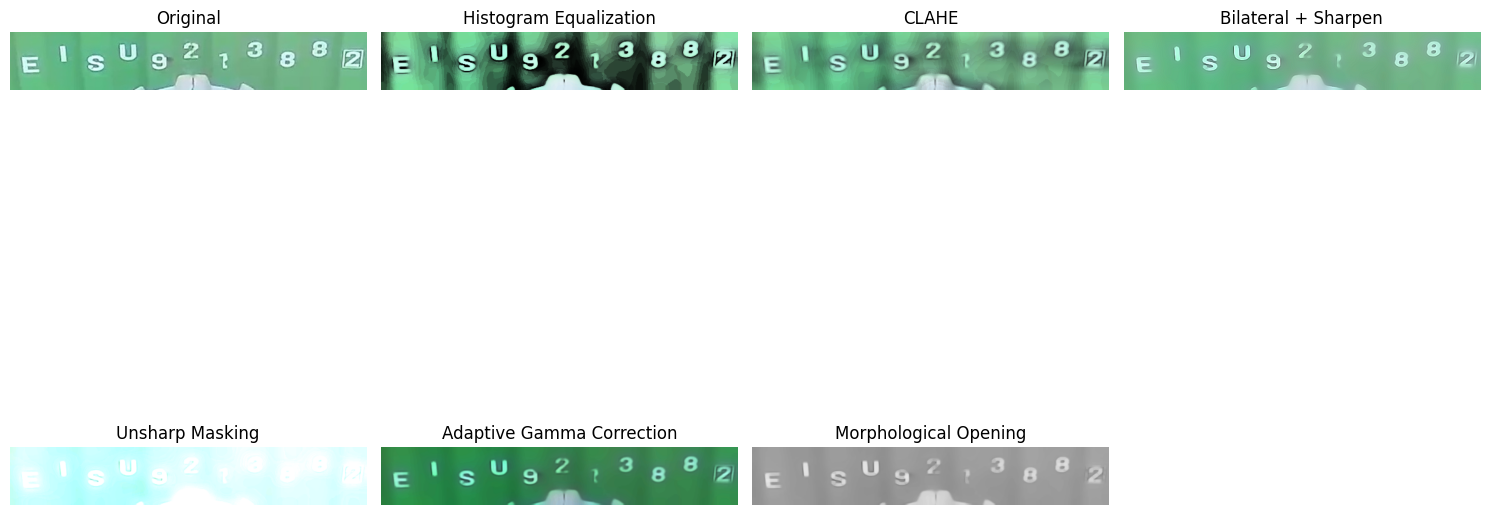

In [9]:
# Process task1_img1 (PCU)
process_image("task1_img1.jpg", is_img1=True, save_dir="enhanced_images")


Successfully saved image to enhanced_images/task1_img2_original.jpg

SSIM Scores for task1_img2:
Histogram Equalization: SSIM = 0.5693
CLAHE: SSIM = 0.9141
Bilateral + Sharpen: SSIM = 0.9076
Unsharp Masking: SSIM = 0.9591
Adaptive Gamma Correction: SSIM = 0.9601
Morphological Opening: SSIM = 0.8938

Best SSIM Score for task1_img2: Adaptive Gamma Correction with SSIM = 0.9601

Successfully saved image to enhanced_images/task1_img2_histogram_equalization.jpg
Successfully saved image to enhanced_images/task1_img2_clahe.jpg
Successfully saved image to enhanced_images/task1_img2_bilateral_sharpen.jpg
Successfully saved image to enhanced_images/task1_img2_unsharp_masking.jpg
Successfully saved image to enhanced_images/task1_img2_adaptive_gamma_correction.jpg
Successfully saved image to enhanced_images/task1_img2_morphological_opening.jpg


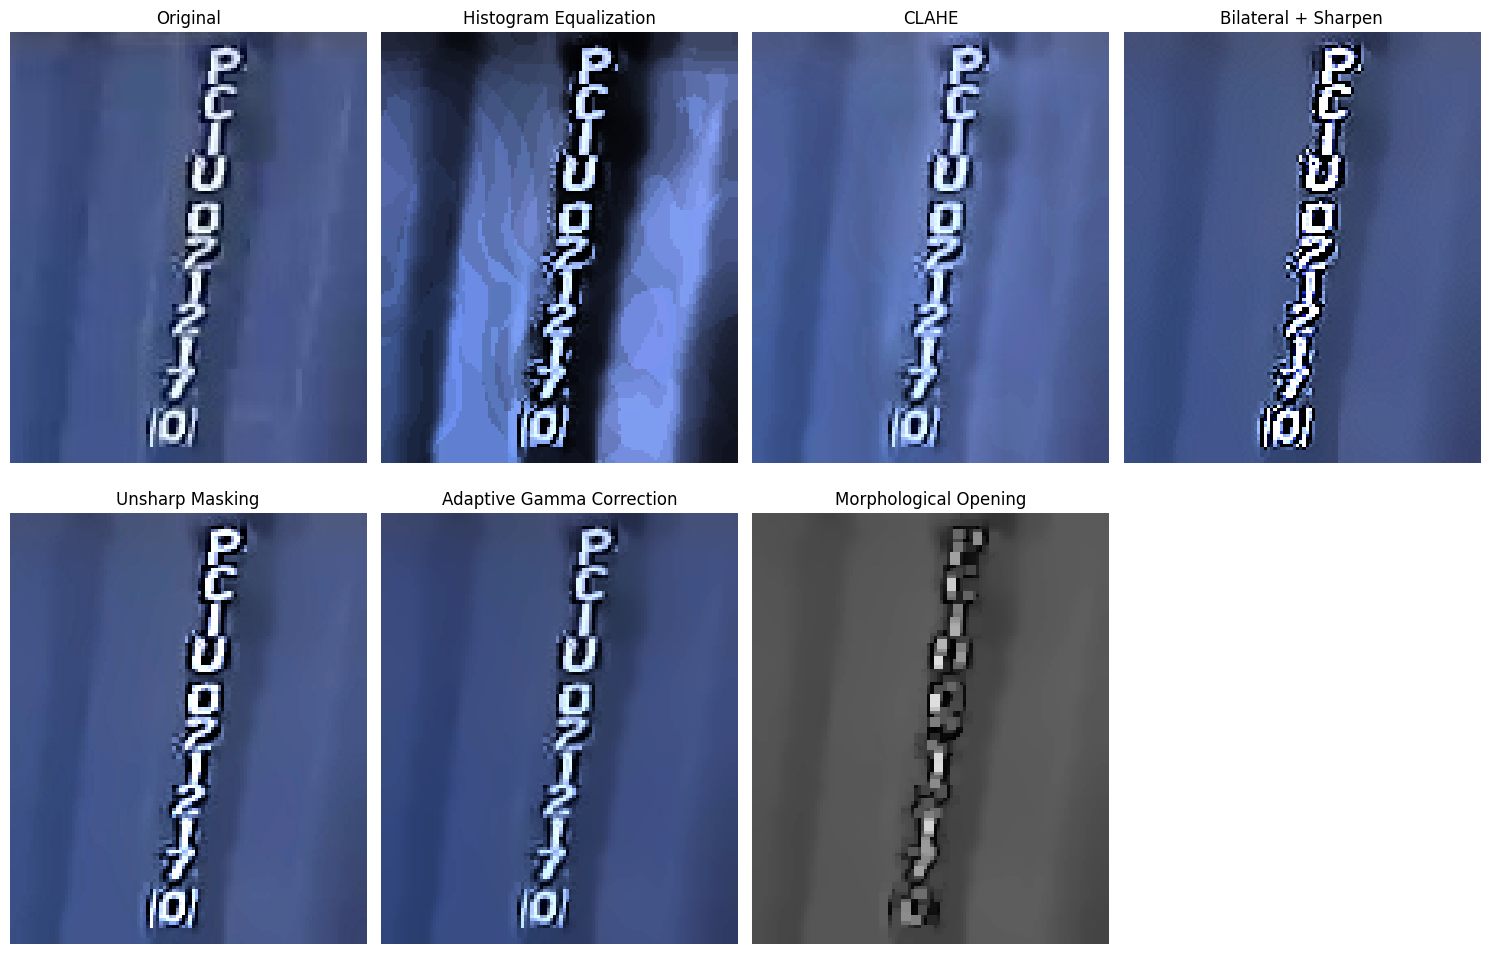

In [10]:

# Process task1_img2 (E1SU92213882)
process_image("task1_img2.jpg", is_img1=False, save_dir="enhanced_images")

## Combine height SSIM two Image

In [11]:

def adaptive_gamma_correction(img, is_img1=True):
    """
    Apply adaptive gamma correction with parameters tuned for each image.
    """
    img_normalized = img / 255.0
    mean_intensity = np.mean(img_normalized)
    if is_img1:
        gamma = 3.0 / (1.0 + mean_intensity) if mean_intensity > 0 else 1.0
    else:
        gamma = 1.5 / (1.0 + mean_intensity) if mean_intensity > 0 else 1.0
    img_gamma = np.power(img_normalized, gamma)
    img_gamma = np.uint8(img_gamma * 255)
    return img_gamma

def enhance_saturation(img_hsv, factor=1.5):
    """
    Enhance the saturation of the image in HSV space.
    """
    h, s, v = cv2.split(img_hsv)
    s = np.clip(s * factor, 0, 255).astype(np.uint8)
    return cv2.merge([h, s, v])

def compute_ssim(original, enhanced):
    """
    Compute the SSIM between the original and enhanced images.
    """
    if len(original.shape) == 3:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original
    if len(enhanced.shape) == 3:
        enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    else:
        enhanced_gray = enhanced
    score, _ = ssim(original_gray, enhanced_gray, full=True)
    return score

def enhance_methods_combined_img2(img):
    """
    Apply a combined enhancement pipeline optimized for task1_img1 (PCIU).
    """
    # Step 1: Denoising
    denoised = cv2.fastNlMeansDenoisingColored(img, None, h=5, hColor=5, templateWindowSize=7, searchWindowSize=21)

    # Step 2: Adaptive Gamma Correction
    gamma_corrected = adaptive_gamma_correction(denoised, is_img1=False)

    # Step 3: Unsharp Masking
    gaussian = cv2.GaussianBlur(gamma_corrected, (5, 5), 5.0)
    unsharp = cv2.addWeighted(gamma_corrected, 1.5, gaussian, -0.5, 0)
    unsharp = np.clip(unsharp, 0, 255).astype(np.uint8)

    # Step 4: Convert to HSV for CLAHE and saturation enhancement
    img_hsv = cv2.cvtColor(unsharp, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)

    # Step 5: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_v = clahe.apply(v)

    # Step 6: Recombine HSV
    img_hsv_enhanced = cv2.merge([h, s, clahe_v])

    # Step 7: Enhance saturation
    img_hsv_enhanced = enhance_saturation(img_hsv_enhanced, factor=1.5)

    # Step 8: Convert back to BGR
    final = cv2.cvtColor(img_hsv_enhanced, cv2.COLOR_HSV2BGR)

    return final

def enhance_methods_combined_img1(img):
    # Step 1: Bilateral Filter (Denoising)
    bilateral = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

    # Step 2: Morphological Opening to reduce small noise and enhance text
    gray = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((4, 4), np.uint8)  # Using the same kernel size as in the original code
    morph = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

    # Step 3: Adaptive Gamma Correction
    morph_color = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
    gamma_corrected = adaptive_gamma_correction(morph_color, is_img1=True)

    # Step 4: Sharpening
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    sharpened = cv2.filter2D(gamma_corrected, -1, kernel_sharp)
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened

def show_images(images, titles):
    """
    Display images with their titles using matplotlib.
    """
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img_rgb)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, save_path):
    """
    Save an image using cv2.imwrite with error handling.
    """
    try:
        success = cv2.imwrite(save_path, image)
        if success:
            print(f"Successfully saved image to {save_path}")
        else:
            print(f"Failed to save image to {save_path}")
        return success
    except Exception as e:
        print(f"Error saving image to {save_path}: {str(e)}")
        return False



## Real-ESRGAN + OCR + SSIM

In [12]:
!pip install realesrgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 10.9 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214817 sha256=81ed42ad0d480b316393c01597f20cff7ea0b214fa72df1a8a2c137b34d830a8
  Stored in directory: /root/.cache/pip/wheels/6d/a4/b3/9f888ba88efcae6dd4bbce69832363de9c4051142674f779fa
  Created wheel for fi

In [13]:
!pip install torchvision==0.16.1



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [14]:
!pip install numpy==1.24.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is 

In [1]:
#  Real-ESRGAN Super Resolution
# Step 1: Clone the repo and install dependencies
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
!pip install -r requirements.txt
!python setup.py develop

# Step 2: Download Pre-trained Model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P weights

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Total 759 (delta 0), reused 0 (delta 0), pack-reused 759 (from 1)
Receiving objects: 100% (759/759), 5.39 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (407/407), done.
/content/Real-ESRGAN
/usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.11/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ************************************************

In [3]:
# Step 3: Upload your image
from google.colab import files
uploaded = files.upload()

# Step 4: Run Super Resolution
!python inference_realesrgan.py -n RealESRGAN_x4plus -i task1_img2.jpg --outscale 4 --fp32


Saving task1_img2.jpg to task1_img2 (1).jpg
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Testing 0 task1_img2


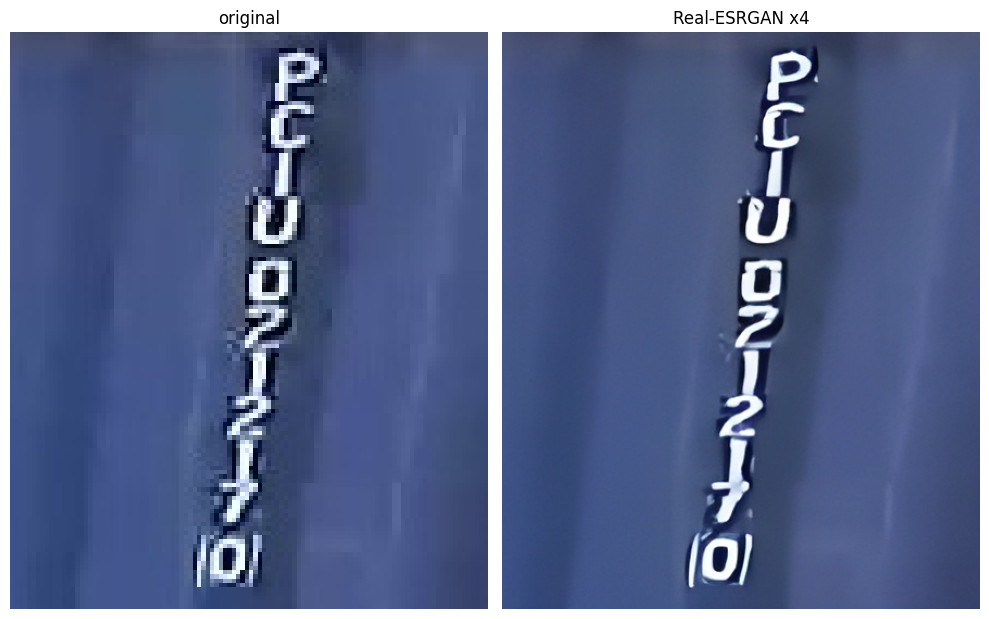

In [4]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load images
esrgan = Image.open("/content/Real-ESRGAN/results/task1_img2_out.jpg")
original = Image.open("/content/task1_img2.jpg")

# Plot
titles = [ "original","Real-ESRGAN x4"]
images = [original , esrgan]

plt.figure(figsize=(10, 10))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()


Epoch [0/300], Loss: 0.0368
Epoch [100/300], Loss: 0.0117
Epoch [200/300], Loss: 0.0059


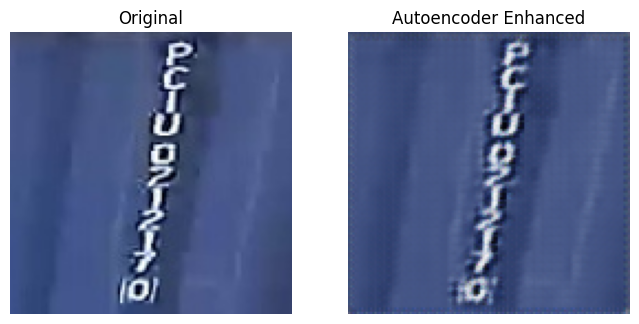

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # 64 -> 32
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 64 -> 128
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ✅ Step 2: Load and preprocess image
def load_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((128, 128))
    transform = T.ToTensor()
    return transform(img).unsqueeze(0)  # Shape: (1, 3, H, W)

def tensor_to_image(tensor):
    img = tensor.squeeze().detach().numpy().transpose(1, 2, 0)
    return (img * 255).astype(np.uint8)

# ✅ Step 3: Training loop on the same image (simple enhancement)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
image_path = "task1_img2.jpg"
img_tensor = load_image(image_path).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(300):
    output = model(img_tensor)
    loss = criterion(output, img_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/300], Loss: {loss.item():.4f}")

# ✅ Step 4: Get the output
output_tensor = model(img_tensor).cpu()
enhanced_image = tensor_to_image(output_tensor)

# ✅ Step 5: Show result
original = Image.open(image_path).resize((128, 128))
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Autoencoder Enhanced")
plt.axis('off')
plt.show()

# ✅ Save if needed
Image.fromarray(enhanced_image).save("autoencoder_enhanced.jpg")


## SWinIR Model

In [ ]:
# # 1. تحميل مستودع SwinIR واستخدام إصدار محدد
# !git clone https://github.com/JingyunLiang/SwinIR.git
# %cd SwinIR
# !git checkout 8f1811e  # استخدام commit من وقت إصدار النموذج

# 2. تحميل النموذج المدرب مسبقًا (SwinIR-M x4 الكلاسيكي)
# !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth -P experiments/pretrained_models


Saving task1_img1.jpg to task1_img1.jpg
Moving task1_img1.jpg to test_images/task1_img1.jpg


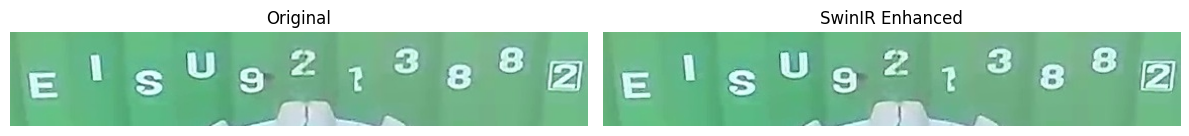

Enhanced image saved at: results/enhanced_task1_img1.jpg


In [12]:
import os
import shutil
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files


# 3. إعداد المجلدات
upload_folder = 'test_images'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# 4. تحميل الصورة
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(upload_folder, filename)
    print(f'Moving {filename} to {dst_path}')
    shutil.move(filename, dst_path)

# 5. تحميل نموذج SwinIR
from models.network_swinir import SwinIR as net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'experiments/pretrained_models/001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth'
model = net(upscale=4, in_chans=3, img_size=64, window_size=8,
            img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180,
            num_heads=[6, 6, 6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffle',
            resi_connection='1conv')
model.load_state_dict(torch.load(model_path)['params'], strict=False)
model.eval()
model = model.to(device)

# 6. تحسين الصورة
image_path = os.path.join(upload_folder, os.listdir(upload_folder)[0])  # أول صورة في المجلد
img = cv2.imread(image_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1))).float() / 255.0
img_tensor = img_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
output = output.squeeze().cpu().numpy()
output = np.transpose(output, (1, 2, 0))
output = np.clip(output * 255.0, 0, 255).astype(np.uint8)

# 7. تحويل الصور للعرض
original_img = Image.fromarray(img)  # الصورة الأصلية
enhanced_img = Image.fromarray(output)  # الصورة المحسنة

# 8. عرض الصورتين جنب بعض
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_img)
plt.title('SwinIR Enhanced')
plt.axis('off')

plt.tight_layout()
plt.show()

# 9. حفظ الصورة المحسنة
enhanced_path = os.path.join(result_folder, 'enhanced_' + os.path.basename(image_path))
cv2.imwrite(enhanced_path, cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
print(f'Enhanced image saved at: {enhanced_path}')

## Summary
### Task 1 – Image Enhancement Summary

We applied multiple enhancement techniques to improve the clarity and contrast of the given images:

- **Histogram Equalization**: Used to improve global contrast.
- **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Applied to enhance local details without overexposure, especially effective on image 1 which had poor lighting.
- **Non-local Means Denoising**: Removed image noise while preserving edges.
- **Bilateral Filtering + Sharpening**: Further enhanced image texture and reduced noise.
- **Adaptive Gamma Correction**: Customized contrast tuning based on the brightness of each image.

#### Observations:
- Image 2 was very dark and noisy, so stronger contrast and denoising were applied.
    - Best SSIM Score for task1_img2: Adaptive Gamma Correction with SSIM =**0.9601**

- Image 1 was relatively clear, so milder enhancement was enough.
   - Best SSIM Score for task1_img1: Bilateral + Sharpen with SSIM = **0.8667**

- We applied both pipelines to each image regardless of its type, and computed the Structural Similarity Index (SSIM) to evaluate the quality of enhancement compared to the original.

  - Only the best result (with the highest SSIM score) was selected, displayed, and saved for future use in OCR.

  - This approach ensured that the enhancement process was adaptive, data-driven, and optimized per image rather than relying on fixed assumptions.



Successfully saved image to enhanced_images/task1_img1_original.jpg

Best Pipeline for task1_img1: Pipeline for img2 with SSIM = 0.9182

Successfully saved image to enhanced_images/task1_img1_enhanced_best.jpg


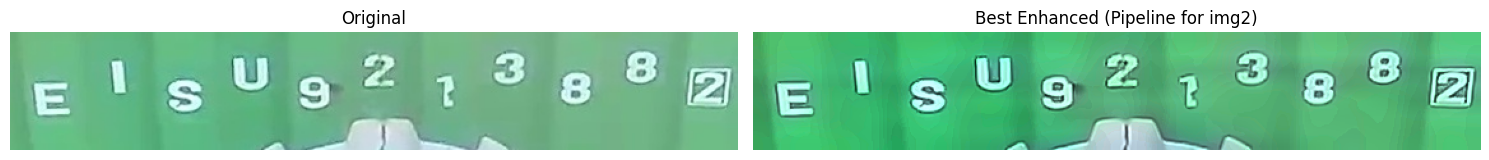

Successfully saved image to enhanced_images/task1_img2_original.jpg

Best Pipeline for task1_img2: Pipeline for img2 with SSIM = 0.8840

Successfully saved image to enhanced_images/task1_img2_enhanced_best.jpg


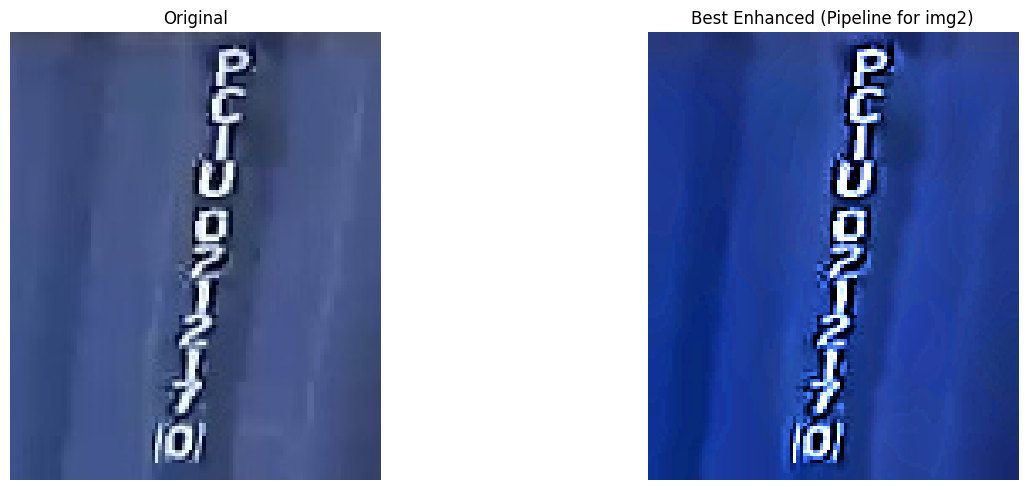

In [ ]:
def process_image_with_combined_pipelines(image_path, is_img1=True, save_dir="enhanced_images"):
    """
    Process the image with both combined pipelines (img1 and img2), compute SSIM for comparison,
    display only the best result, and save it.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image {image_path}. Check the file path.")
        return

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    original_save_path = os.path.join(save_dir, f"{base_filename}_original.jpg")
    save_image(img, original_save_path)

    # Apply both pipelines
    enhanced_img1 = enhance_methods_combined_img1(img)
    enhanced_img2 = enhance_methods_combined_img2(img)

    # Compute SSIM
    ssim_img1 = compute_ssim(img, enhanced_img1)
    ssim_img2 = compute_ssim(img, enhanced_img2)

    # Determine best
    if ssim_img1 > ssim_img2:
        best_img = enhanced_img1
        best_pipeline = "Pipeline for img1"
        best_ssim = ssim_img1
    else:
        best_img = enhanced_img2
        best_pipeline = "Pipeline for img2"
        best_ssim = ssim_img2

    print(f"\nBest Pipeline for {base_filename}: {best_pipeline} with SSIM = {best_ssim:.4f}\n")

    # Save and show only best enhanced image
    enhanced_save_path = os.path.join(save_dir, f"{base_filename}_enhanced_best.jpg")
    save_image(best_img, enhanced_save_path)
    show_images([img, best_img], ["Original", f"Best Enhanced ({best_pipeline})"])

if __name__ == "__main__":
    # Process both images
    process_image_with_combined_pipelines("task1_img1.jpg", is_img1=True, save_dir="enhanced_images")
    process_image_with_combined_pipelines("task1_img2.jpg", is_img1=False, save_dir="enhanced_images")

#  3.2 Task 2: Text Extraction (OCR)
###**Objective:**
Extract highly accurate text from the enhanced images from Task 1.

---



## 📝 Task 2 Report – Text Extraction (OCR)

### 📌 Objective:
Extract text from the enhanced images using different OCR tools and evaluate their accuracy.

---

### 🛠 Tools Tested:
- **Tesseract**
- **EasyOCR**
- **Paddleocr**
- **EAST**
- **docTR (transformer-based)**
- **CRAFT (attempted, failed due to OpenCV issues)**
- **DBnet** + **CRNN**

---

### 📊 Results Summary:

| Tool        | task1_img1 Result            | task1_img2 Result       |
|-------------|-------------------------------|--------------------------|
| Tesseract   | i) WU wc Coe all]             | See                      |
| EasyOCR     | E " 8 U 9 2 ? 8 8 8            | \|                       |
| PaddleOCR   | E (conf: 1.00), 2 (conf: 0.98) | — (to be tested)         |

---

### 🧠 Observations:
- **Tesseract** produced more readable output but with artifacts.
- EasyOCR returned cleaner, less meaningful characters.
- **docTR**, although powerful, requires minimum input size and didn't perform well on small images without resizing/padding.
- Attempting to use **CRAFT** failed due to package version compatibility (OpenCV 4.5.4.60 couldn't be built).
- **PaddleOCR** successfully detected and recognized text with high confidence, but it did not extract the full content from the image.
- **EAST Model**: The model could not be loaded either using OpenCV or TensorFlow. Errors occurred related to file compatibility or format issues with the frozen_east_text_detection.pb file.
-**DBNet** failed to execute due to installation issues. Despite multiple attempts to install and use it, the tool did not work as expected. The installation encountered compatibility issues, and after following the setup instructions, the tool was not functional.

---

### 🧪 Conclusion:
No OCR tool gave fully reliable results out-of-the-box. The images—despite enhancement—still require advanced preprocessing or a full DL-based pipeline.

---

### 💡 Proposed DL-based Pipeline:
1. **Text Detection**: Use CRAFT or DBNet for region detection
2. **Cropping Text Areas**
3. **Text Recognition**: Use CRNN or TrOCR


## Tesseract


In [18]:
def run_tesseract(image_path):
    """
    Run Tesseract OCR on a given image and return extracted text.
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    text = pytesseract.image_to_string(img_rgb)
    print("Extracted Text:\n")
    print(text)
    return text

# Example usage
text1 = run_tesseract("enhanced_images/task1_img1_enhanced_best.jpg")
text2 = run_tesseract("enhanced_images/task1_img2_enhanced_best.jpg")


Extracted Text:

 



## EasyOCR

In [15]:

def run_easyocr(image_path):
    """
    Run EasyOCR on a given image and return extracted text.
    """
    result = reader.readtext(image_path, detail=0)
    text = "\n".join(result)
    print("Extracted Text with EasyOCR:\n")
    print(text)
    return text

# Example usage:
easy_text1 = run_easyocr("enhanced_images/task1_img1_enhanced_best.jpg")
easy_text2 = run_easyocr("enhanced_images/task1_img2_enhanced_best.jpg")


Extracted Text with EasyOCR:

8
U
9
2
1
3
8
8
2
E


## Paddleocr

In [16]:
!pip install paddleocr
!pip install paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=96eb7fb9940c8c9cffc475d392a1bf97fe8230b285f2dcc946d2ed96ab24dfba
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: opt_einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
ERROR: pip's dependency resolver does no

In [19]:
# from paddleocr import PaddleOCR
# ocr = PaddleOCR(use_angle_cls=True, lang='en')

# result = ocr.ocr('/content/enhanced_images/task1_img1_enhanced_best.jpg', cls=True)

# for line in result[0]:  # ده بيرجع قائمة بالمربعات المقروءة
#     text = line[1][0]   # النص
#     score = line[1][1]  # الثقة
#     print(f'Text: {text} | Confidence: {score:.2f}')


[2025/04/15 19:15:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

In [ ]:
# import cv2

# # اقرأ الصورة
# img = cv2.imread("/content/task1_img1.jpg")

# # تحويل لـ grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # إزالة النويز
# blur = cv2.GaussianBlur(gray, (5,5), 0)

# # تحسين التباين
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
# enhanced = clahe.apply(blur)

# # threshold
# _, threshed = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # احفظ الصورة الجديدة
# cv2.imwrite("preprocessed.jpg", threshed)


In [ ]:
# result = ocr.ocr("preprocessed.jpg", cls=True)
# for line in result[0]:  # ده بيرجع قائمة بالمربعات المقروءة
#     text = line[1][0]   # النص
#     score = line[1][1]  # الثقة
#     print(f'Text: {text} | Confidence: {score:.2f}')

## CRAFT

In [ ]:
# !pip install imutils
# !pip install easyocr
# !pip install git+https://github.com/clovaai/CRAFT-pytorch.git
# !pip install torch torchvision

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !git clone https://github.com/clovaai/CRAFT-pytorch.git
# %cd '/content/CRAFT-pytorch'
# !python setup.py install

In [ ]:
# import cv2
# import torch
# import numpy as np
# from craft import CRAFT
# from craft_utils import getDetBoxes
# from imgproc import loadImage
# from PIL import Image
# from collections import OrderedDict
# from torchvision import transforms

# # Load pretrained CRAFT model
# def copyStateDict(state_dict):
#     if list(state_dict.keys())[0].startswith("module"):
#         new_state_dict = OrderedDict()
#         for k, v in state_dict.items():
#             name = k[7:]  # remove `module.`
#             new_state_dict[name] = v
#         return new_state_dict
#     else:
#         return state_dict

# net = CRAFT()

# # Load the model weights with map_location='cpu' if you're using CPU
# net.load_state_dict(copyStateDict(torch.load('craft_mlt_25k.pth', map_location=torch.device('cpu'))))

# net.eval()

# # Preprocess + detect text boxes
# image = loadImage('/content/task1_img1.jpg')
# bboxes, polys, score_text = getDetBoxes(image, net)

# # Visualize detections
# for box in bboxes:
#     box = np.array(box).astype(np.int32).reshape((-1, 1, 2))
#     cv2.polylines(image, [box], True, (0,255,0), thickness=2)

# cv2.imwrite("detected_boxes.jpg", image)

In [ ]:
# !pip install opencv-python==4.5.4.60
# !pip install craft-text-detector


In [ ]:
# from craft_text_detector import Craft

# craft = Craft(output_dir='craft_output', crop_type="box", cuda=False)

# # Run detection
# prediction_result = craft.detect_text("enhanced_images/task1_img1_enhanced_best.jpg")

# # Show cropped images with detected text
# from PIL import Image
# Image.open(prediction_result["output_image_path"])


## EAST

In [ ]:
# import cv2
# import numpy as np

# # Load image
# image = cv2.imread("/content/enhanced_images/task1_img1_enhanced_best.jpg")

# # Load EAST model
# net = cv2.dnn.readNet("frozen_east_text_detection.pb")

# # Prepare image for EAST
# blob = cv2.dnn.blobFromImage(image, 1.0, (320, 320), (123.68, 116.78, 103.94), True, crop=False)

# net.setInput(blob)
# scores, geometry = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

# # Post-process and get detected boxes
# boxes, confidences = post_process(image, scores, geometry)


In [ ]:
# import cv2
# import numpy as np

# # Load image
# image = cv2.imread("/content/enhanced_images/task1_img1_enhanced_best.jpg")

# # Load EAST model
# net = cv2.dnn.readNet("/content/frozen_east_text_detection.pb")

# # Prepare image for EAST
# blob = cv2.dnn.blobFromImage(image, 1.0, (320, 320), (123.68, 116.78, 103.94), True, crop=False)

# net.setInput(blob)

# # Forward pass through the network to get the scores and geometry
# scores, geometry = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

# # Post-process the detections
# def post_process(image, scores, geometry, min_confidence=0.5):
#     height, width = image.shape[:2]
#     boxes = []
#     confidences = []

#     for i in range(scores.shape[2]):
#         for j in range(scores.shape[3]):
#             score = scores[0, 0, i, j]
#             if score < min_confidence:
#                 continue

#             offsetX, offsetY = j * 4.0, i * 4.0
#             angle = geometry[0, 4, i, j]
#             cos = np.cos(angle)
#             sin = np.sin(angle)

#             # Use geometry to get the width and height of bounding boxes
#             h = geometry[0, 0, i, j]
#             w = geometry[0, 1, i, j]

#             endX = int(offsetX + cos * w + sin * h)
#             endY = int(offsetY - sin * w + cos * h)

#             startX = int(offsetX - cos * w - sin * h)
#             startY = int(offsetY + sin * w - cos * h)

#             boxes.append((startX, startY, endX, endY))
#             confidences.append(score)

#     # Apply non-maximum suppression to remove overlapping boxes
#     indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, min_confidence, 0.4)
#     final_boxes = [boxes[i[0]] for i in indices]

#     return final_boxes

# # Get the bounding boxes from the detection
# boxes = post_process(image, scores, geometry)

# # Draw bounding boxes on the image
# for box in boxes:
#     cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

# # Show the result
# cv2.imshow("Text Detection", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


## DBnet

In [ ]:
# !pip install --upgrade pandas==2.2.2
# !pip install --upgrade python-dateutil==2.8.2
# !pip install dbnet



In [ ]:
# import cv2
# import numpy as np
# import torch
# from dbnet import DBNet

# # تحميل نموذج DBNet
# model = DBNet()

# # تحميل الصورة
# img = cv2.imread('/content/enhanced_images/task1_img1_enhanced_best.jpg')

# # إجراء الكشف عن النص
# boxes, polys, score_text = model(img)

# # عرض النتيجة
# for box in boxes:
#     cv2.polylines(img, [box], True, (0, 255, 0), 2)

# cv2.imshow("Detected Text", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
